In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(0.5,0.5)
])

In [4]:
batch_size = 64

dataset = datasets.MNIST(root='./DataSet/MNIST', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [5]:
for img, _ in data_loader:
	print(img.shape)
	break

torch.Size([64, 1, 28, 28])


In [ ]:
latent_dim = 100
batch_size = 64
img_size = 28
channels = 1
sample_dir = "MNIST-Img-Output"
os.makedirs(sample_dir, exist_ok=True)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.model = nn.Sequential(
            
			nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
			nn.BatchNorm2d(in_channels),
			nn.ReLU(inplace=True),

			nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1), 
			nn.BatchNorm2d(in_channels),
		)
    
    def forward(self, x):
        return self.model(x) + x # output size : [B, C, H, W]

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=1):
        super().__init__()
        # Input : [B, latent_dim=100]
        self.fc = nn.Linear(latent_dim, 128*7*7) # [B, 128, 7, 7]
        
        self.model = nn.Sequential(
			ResidualBlock(128), # (B, 128, 7, 7)
            nn.Upsample(scale_factor=2), # (B, 128, 14, 14)
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # (B, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            ResidualBlock(64), # (B, 64, 14, 14)
            nn.Upsample(scale_factor=2), # (B, 64, 28, 28)
            nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1), # (B, 1, 28, 28)
            nn.Tanh()
		)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.model(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input : [B, 1, 28, 28]
			nn.Conv2d(channels, 64, kernel_size=3, stride=2, padding=1), # (64, 14, 14)
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (128, 7, 7)
			nn.BatchNorm2d(128),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Flatten(), # [128 * 7 * 7]
			nn.Linear(128 * 7 * 7, 1),
			nn.Sigmoid()
		)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
EPOCHS = 10

for epoch in range(EPOCHS):
    
    for i, (imgs, _) in enumerate(data_loader):
        
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)
        
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # train discriminator
        optimizer_d.zero_grad()
        
        real_output = discriminator(real_imgs)
        real_loss = criterion(real_output, valid)
        
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_output, fake)
        
        total_loss = real_loss + fake_loss
        total_loss.backward()
        optimizer_d.step()
        
        # train genereator
        optimizer_g.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        gen_output = discriminator(gen_imgs)
        generator_loss = criterion(gen_output, valid)
        generator_loss.backward()
        optimizer_g.step()
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss D: {total_loss:.4f}, Loss G: {generator_loss:.4f}")

Epoch [1/10], Loss D: 1.4185, Loss G: 1.2253
Epoch [2/10], Loss D: 1.4150, Loss G: 0.5682
Epoch [3/10], Loss D: 1.2822, Loss G: 1.6398
Epoch [4/10], Loss D: 1.2988, Loss G: 0.8376
Epoch [5/10], Loss D: 1.3674, Loss G: 1.4043
Epoch [6/10], Loss D: 1.2866, Loss G: 1.2834
Epoch [7/10], Loss D: 1.1435, Loss G: 0.6998
Epoch [8/10], Loss D: 1.1042, Loss G: 1.0202
Epoch [9/10], Loss D: 1.1372, Loss G: 0.9935
Epoch [10/10], Loss D: 1.3804, Loss G: 1.1428


In [12]:
with torch.no_grad():
	z = torch.randn(batch_size, latent_dim).to(device)
	fake_imgs = generator(z)
	save_image(fake_imgs[:25], os.path.join(sample_dir, "sample_{}.png".format(epoch)), nrow=10, normalize=True)


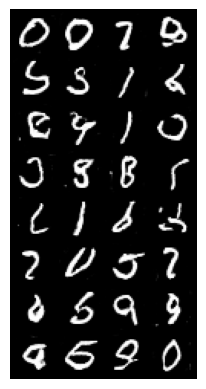

In [17]:
grid = torchvision.utils.make_grid(fake_imgs, nrow=4, normalize=True).cpu()
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()